In [1]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change system patch to be able to access the custom modules (helper_functions, normalization)
import sys
sys.path.append('/content/drive/MyDrive/python_functions')

In [ ]:
#@title Import

import os
import numpy as np
import glob
from pathlib import Path

import csv
import datetime
import random

from osgeo import osr
from osgeo import gdal
import json

from pydantic import BaseModel

import keras
from keras import utils
from keras.applications import VGG16
from keras.layers import Input
from keras import metrics
from keras.callbacks import EarlyStopping

import tensorflow as tf

from keras.models import model_from_json

from matplotlib import pyplot as plt

import helper_functions
import NN_functions
import normalization

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#@title Parameters

base_dir=Path('/content/drive/MyDrive/ESA_GDA_UGS/Kinshasa')

#Data
training_data_dir = base_dir.joinpath('data')
dir_img = training_data_dir.joinpath('img_448px')
dir_lbl = training_data_dir.joinpath('lbl_448px')

random_seed = 42

band_list= ['b01', 'b02', 'b03']
size = 448
shape=(size,size,len(band_list))
inputs= Input(shape)

#class_codes = [1,2,3,4,5,6] #L1
#class_codes = [1,2,3,4,5,6,7] #L2_v2
#class_codes = list(range(1,15)) #L3
class_codes = list(range(1,9)) #NBS specific
#class_labels=['high vegetation','low vegetation','locations','water','buildings','other'] #L1
#class_labels=['high vegetation','low vegetation','bare','paved','water','buildings','other'] #L2
#class_labels=['trees','shrub','low plants','mixt/grass','bare','between buildings','courtyard','parking','square','street','flowing','stagnant','buildings','other'] #L3
class_labels=['trees','shrub','low vegetation','bare','paved','buildings','water','other'] #NBS specific
num_classes = len(class_codes)

split_train = 0.7
#split_train = 1
split_valid = 0.1
#split_valid = 0

do_horizontal_flip = True
do_vertical_flip = True
do_rotation = True

# MODEL
#weights=None #in case of using more than 3 input bands

version='scenario_06'
n_epochs=50
dropout=0.3
kernel_size=3
batch_size=8
patience=5
weights='imagenet'

activation = 'softmax'
optimizer= "Adam"                                                           #Adam, rmsprop, keras.optimizers.Adam(learning_rate)
loss="categorical_crossentropy"                                             #OR: mse, sparse_categorical_crossentropy, keras.losses.BinaryCrossentropy(from_logits=True)
metrics=["categorical_accuracy"]                                             #OR: mae, keras.metrics.BinaryAccuracy(), ,tf.keras.metrics.Precision,tf.keras.metrics.Recall https://keras.io/api/metrics/
early_stopping = EarlyStopping(monitor='val_loss',patience=patience)

note='NBS nomenclature, image chips size 448 px, full train data'

current_date = datetime.date.today() # get current date

model_basedir = base_dir.joinpath('models', f'model_{version}')
model_filepath = model_basedir.joinpath(f'model_{version}.json')
model_weights = model_basedir.joinpath(f'model_{version}.h5')

# VERSION CONTROL
path_VC=base_dir.joinpath('version_control.csv')
header = ['version', 'kernel_size', 'n_epochs', 'batch_size','weights', 'num_classes','early_stopping.monitor','patience','img chips size','date','training size (no aug)','training size (with aug)','augmentations','notes']

# OUTPUT - evaluation
output_path = base_dir.joinpath('predict_test', f'{version}_')

In [ ]:
#@title Reproducibility

# Seed value
# Apparently you may use different seed values at each stage
seed_value= random_seed

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

tf.random.set_seed(seed_value)

In [ ]:
#@title Input data loading

helper_functions.removeAUX(dir_img)
helper_functions.removeAUX(dir_lbl)

sample_names = helper_functions.read_file_names(dir_img)
label_names = helper_functions.read_file_names(dir_lbl)

# input data normalization
input_data_normalized, _ = normalization.normalization(sample_names, band_list)

#loading label data
target_data_processed_step1 = helper_functions.target_data_process(helper_functions.image_to_array_gdal(label_names))
target_data_processed = target_data_processed_step1[:,:,:,1:] #keras.utils.to_categorical: class values into integers from 0 to "num_classes - 1"; no values 0 in my labels, dropping the first column of the 4th dimension where the zeros are considered

In [ ]:
#@title Split train - test - valid

L = len(sample_names)

ind_all = helper_functions.shuffle_ind(L,random_seed)

L_train = int(split_train*L); L_valid = int(split_valid*L); L_test = L - L_train - L_valid

ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]
ind_train_shuffle = helper_functions.shuffle_ind(L_train,random_seed)[:L]
ind_test_shuffle = helper_functions.shuffle_ind(L_test,random_seed)[:L]

print(f"Training:validation:testing = {L_train}:{L_valid}:{L_test}")

train_input=input_data_normalized[ind_train][ind_train_shuffle]
valid_input=input_data_normalized[ind_valid]
test_input=input_data_normalized[ind_test][ind_test_shuffle]

train_target = target_data_processed[ind_train][ind_train_shuffle]
valid_target = target_data_processed[ind_valid]
test_target = target_data_processed[ind_test][ind_test_shuffle]

train_input_size_orig=L_train

Training:validation:testing = 109:15:32


In [ ]:
#@title Augmentations

class Config(BaseModel):
  horizontal_flip: bool
  vertical_flip: bool
  rotation: bool

config=Config(horizontal_flip=do_horizontal_flip,vertical_flip=do_vertical_flip,rotation=do_rotation)

train_input, train_target, num_training_samples=helper_functions.augmentations(train_input, train_target, config)

(436, 448, 448, 3)


In [ ]:
# display the satelite and target data
"""
plt.figure()
f, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1, 8, sharey=True)
ax0.imshow(aug_input_data_normalized_stack[0,:,:,0])
ax1.imshow(aug_target_data_processed_stack[0,:,:,0])
ax2.imshow(aug_input_data_normalized_stack[1,:,:,0])
ax3.imshow(aug_target_data_processed_stack[1,:,:,0])
ax4.imshow(aug_input_data_normalized_stack[2,:,:,0])
ax5.imshow(aug_target_data_processed_stack[2,:,:,0])
ax6.imshow(aug_input_data_normalized_stack[3,:,:,0])
ax7.imshow(aug_target_data_processed_stack[3,:,:,0])
"""

'\nplt.figure()\nf, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1, 8, sharey=True)\nax0.imshow(aug_input_data_normalized_stack[0,:,:,0])\nax1.imshow(aug_target_data_processed_stack[0,:,:,0])\nax2.imshow(aug_input_data_normalized_stack[1,:,:,0])\nax3.imshow(aug_target_data_processed_stack[1,:,:,0])\nax4.imshow(aug_input_data_normalized_stack[2,:,:,0])\nax5.imshow(aug_target_data_processed_stack[2,:,:,0])\nax6.imshow(aug_input_data_normalized_stack[3,:,:,0])\nax7.imshow(aug_target_data_processed_stack[3,:,:,0])\n'

In [ ]:
#@title Compile and fit model

models_dir = base_dir.joinpath('models')

if not models_dir.exists():
   print('models directory does not exist')
   os.makedirs(models_dir)

#vgg16
vgg16 = VGG16(input_tensor=inputs,include_top=False, weights=weights)
model = NN_functions.vgg16_unet(vgg16,inputs,num_classes,dropout,kernel_size,activation)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # https://keras.io/api/optimizers/adam/
#model.summary()

#src: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
if os.path.exists(model_filepath): # generally, i dont need this section since creating predictions outside Colab...
    print('model exists')

    # load json and create model
    json_file = open(model_filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

    # load weights into new model
    model.load_weights(model_weights)
    print("Model loaded from disk")
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # https://keras.io/api/optimizers/adam/
    history=model.fit(x=train_input,y=train_target, epochs=n_epochs, validation_data=(valid_input,valid_target),batch_size=batch_size,callbacks=[early_stopping])

else:
    print('model doesn\'t exist')
    history=model.fit(x=train_input,y=train_target, epochs=n_epochs, validation_data=(valid_input,valid_target),batch_size=batch_size,callbacks=[early_stopping])
    n_epochs_real = len(history.history['loss']) #src: https://github.com/keras-team/keras/issues/1766

    # serialize model to JSON
    model_json = model.to_json()

    os.mkdir(model_basedir)
    with open(model_filepath, "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(model_weights)
    print("Model saved to disk")

58889256/58889256 [==============================] - 3s 0us/step
model doesn't exist
Epoch 1/50
55/55 [==============================] - 149s 2s/step - loss: 1.4165 - categorical_accuracy: 0.5186 - val_loss: 4.5980 - val_categorical_accuracy: 0.2251
Epoch 2/50
55/55 [==============================] - 73s 1s/step - loss: 1.0362 - categorical_accuracy: 0.6416 - val_loss: 9.7897 - val_categorical_accuracy: 0.4043
Epoch 3/50
55/55 [==============================] - 74s 1s/step - loss: 0.9336 - categorical_accuracy: 0.6738 - val_loss: 1.6804 - val_categorical_accuracy: 0.6232
Epoch 4/50
55/55 [==============================] - 74s 1s/step - loss: 0.8799 - categorical_accuracy: 0.6940 - val_loss: 0.9812 - val_categorical_accuracy: 0.6519
Epoch 5/50
55/55 [==============================] - 74s 1s/step - loss: 0.8327 - categorical_accuracy: 0.7051 - val_loss: 0.8183 - val_categorical_accuracy: 0.6982
Epoch 6/50
55/55 [==============================] - 74s 1s/step - loss: 0.8162 - categorical_a

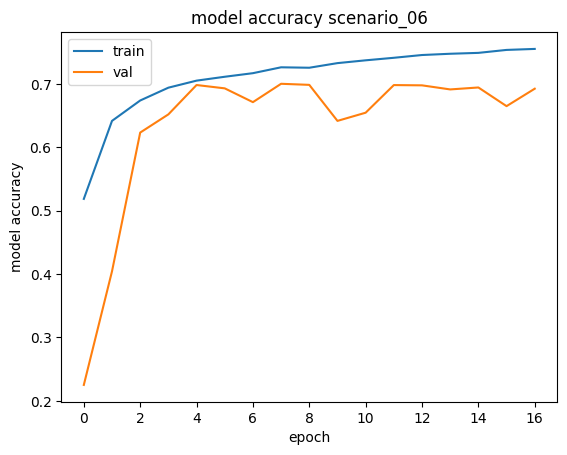

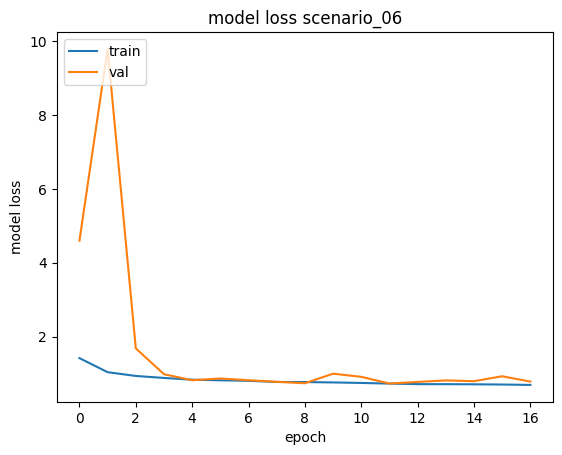

In [ ]:
#@title Plots
helper_functions.plot('model accuracy',history,version,'categorical_accuracy','val_categorical_accuracy')
helper_functions.plot('model loss',history,version,'loss','val_loss')

In [ ]:
#@title Version control

data = [version,kernel_size,n_epochs_real,batch_size,weights,num_classes,early_stopping.monitor,early_stopping.patience,shape,current_date,train_input_size_orig,num_training_samples,str(config.__dict__),note]

if os.path.exists(path_VC):
    with open(path_VC, 'a') as f:
        writer = csv.writer(f)
        writer.writerow(data)
else:
    with open(path_VC, 'w', encoding='UTF8') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write the data
        writer.writerow(data)

In [ ]:
#@title Predict
model_output=model.predict(x=test_input,batch_size=batch_size)

4/4 [==============================] - 2s 473ms/step


In [ ]:
#@title Export data
#import functions_predict

temp=np.array(sample_names)
raster_list=temp[ind_test][ind_test_shuffle]

output_folder_parent = base_dir.joinpath('predictions')
output_folder = output_folder_parent.joinpath(f'predict_test_{version}')

if os.path.exists(output_folder_parent) == False:
  os.mkdir(output_folder_parent)

print(output_folder)
#print(raster_list)
#print(size)

#here we dont create outputs (export=False)
#model_output_classif=helper_functions.output_export(raster_list,L_test,model_output,size,class_codes,output_folder,version)
model_output_classif=helper_functions.output_export(raster_list,L_test,model_output,size,class_codes,output_folder,version,export=True)


/content/drive/MyDrive/ESA_GDA_UGS/Kinshasa/predictions/predict_test_scenario_06


In [ ]:
"""
print(test_target_flatten.shape)
print(model_output_classif_flatten.shape)
print(class_labels)

print(test_target_nonCategorical.shape)
print(model_output_classif.shape)

print(type(test_target_nonCategorical))
#print(model_output_classif)

#print(unique(test_target_nonCategorical))
print(np.unique(test_target_nonCategorical+1))
print(np.unique(model_output_classif))
"""

In [ ]:
#@title Evaluation

#src: https://stackoverflow.com/questions/47380663/numpy-reverse-keras-to-categorical

test_target_nonCategorical_step1=np.argmax(test_target,axis=3)
test_target_nonCategorical=test_target_nonCategorical_step1+1 #add value 1 to every element = class labels go from 1 (for processing reasons (one hot encoding) transfered to values from 0 earlier)

test_target_flatten = test_target_nonCategorical.flatten()

model_output_classif_flatten = model_output_classif.flatten()

cm = confusion_matrix(test_target_flatten, model_output_classif_flatten,labels=class_codes) #true - rows, predict - cols
print(cm)
print()

cr=classification_report(test_target_flatten, model_output_classif_flatten,target_names=class_labels)
print(cr)

[[ 570764  178537  121083    7815     134   57228     424       0]
 [  62003  134258  122680    3608      54   32701      15       0]
 [  60690   52656 1832601   97609    3034   65456    1727       0]
 [  13931     910  184013  347496   45687  107468    7871       0]
 [    736       0    1871   30444   62949   36788    2342       0]
 [  36963    1207   63964  139953   44112 1256842    3449       0]
 [    149       6    4999    4424      88     198  533330       0]
 [   4724     383   11792   10530    1195   14212   42425       0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

         trees       0.76      0.61      0.68    935985
         shrub       0.36      0.38      0.37    355319
low vegetation       0.78      0.87      0.82   2113773
          bare       0.54      0.49      0.52    707376
         paved       0.40      0.47      0.43    135130
     buildings       0.80      0.81      0.81   1546490
         water       0.90      0.98      0.94    543194
         other       0.00      0.00      0.00     85261

      accuracy                           0.74   6422528
     macro avg       0.57      0.58      0.57   6422528
  weighted avg       0.73      0.74      0.73   6422528



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#@title write CM to CSV
#src: https://www.pythontutorial.net/python-basics/python-write-csv-file/
csv_path = base_dir.joinpath('confusion_matrices',f'cm_{version}.csv')

with open(csv_path, 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerows(cm)